In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## VGG16

In [ ]:
# Set paths
base_dir = '/content/gdrive/My Drive/CSE424/Project/LungCancerDataset'
temp_dir = '/content/split_data'
train_dir = os.path.join(temp_dir, 'train')
val_dir = os.path.join(temp_dir, 'validation')
test_dir = os.path.join(temp_dir, 'test')

# Create temporary directories for splitting data
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

    for subset in ['train', 'validation', 'test']:
        for category in ['Benign cases', 'Malignant cases', 'Normal cases']:
            os.makedirs(os.path.join(temp_dir, subset, category))

In [ ]:
# Function to split data into train/validation/test
def split_data(base_dir, train_dir, val_dir, test_dir, split_ratios=(0.7, 0.2, 0.1)):
    for category in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category)
        if os.path.isdir(category_path):
            files = os.listdir(category_path)
            train_files, temp_files = train_test_split(files, test_size=(1 - split_ratios[0]), random_state=42)
            val_files, test_files = train_test_split(temp_files, test_size=(split_ratios[2] / (split_ratios[1] + split_ratios[2])), random_state=42)

            # Copy files to respective directories
            for file_set, target_dir in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
                for file in file_set:
                    shutil.copy(os.path.join(category_path, file), os.path.join(target_dir, category))

# Split data
split_data(base_dir, train_dir, val_dir, test_dir)

In [ ]:
# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Don't shuffle for evaluation
)

Found 766 images belonging to 3 classes.
Found 219 images belonging to 3 classes.
Found 112 images belonging to 3 classes.


In [ ]:
# Load VGG16 base model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
for layer in vgg_base.layers:
    layer.trainable = False

# Build VGG16 model with Batch Normalization
vgg_model = models.Sequential([
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')

# Compile the model
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

vgg_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,139,267 (80.64 MB)

 Trainable params: 6,424,067 (24.51 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

EPOCHS = 20

In [ ]:
# Train VGG16 model
print("Training VGG16...")
vgg_history = vgg_model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Training VGG16...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 583ms/step - accuracy: 0.5897 - loss: 1.1283 - val_accuracy: 0.4932 - val_loss: 2.1737
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 538ms/step - accuracy: 0.7249 - loss: 0.6571 - val_accuracy: 0.5845 - val_loss: 0.9415
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 467ms/step - accuracy: 0.7994 - loss: 0.5051 - val_accuracy: 0.5616 - val_loss: 1.3387
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 435ms/step - accuracy: 0.8144 - loss: 0.4646 - val_accuracy: 0.8447 - val_loss: 0.3665
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 515ms/step - accuracy: 0.8134 - loss: 0.4731 - val_accuracy: 0.8356 - val_loss: 0.3844
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 510ms/step - accuracy: 0.8585 - loss: 0.3527 - val_accuracy: 0.8356 - val_loss: 0.3495
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 484ms/step - accuracy: 0.8594 - loss: 0.3262 - val_accuracy: 0.8858 - val_loss: 0.2503
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.8459 - loss: 0.3768 - val_accuracy: 0.895

In [ ]:
# Evaluate VGG16 model
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(test_data)
print(f"VGG16 Test Accuracy: {vgg_test_accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8780 - loss: 0.2395
VGG16 Test Accuracy: 0.89


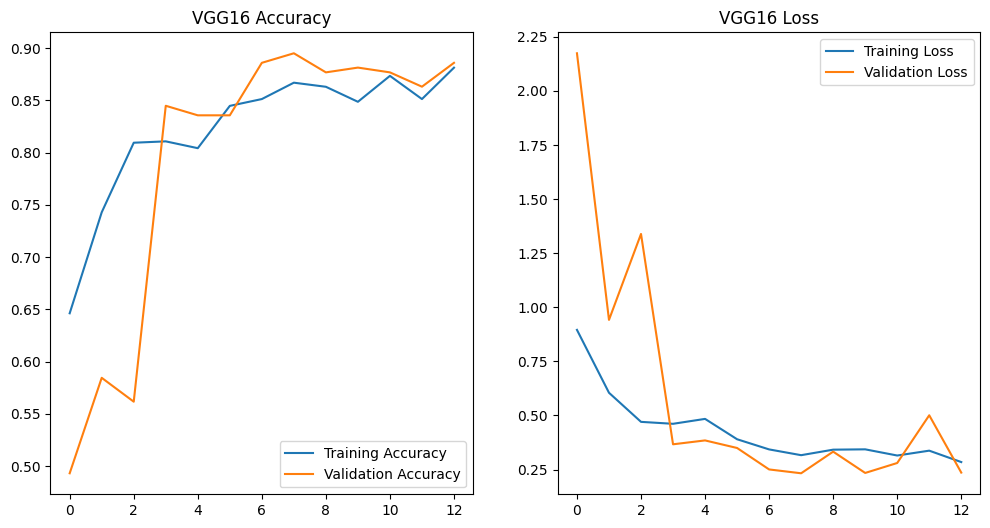

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{model_name} Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{model_name} Loss')

    plt.show()

# Plot history for both models
plot_training_history(vgg_history, "VGG16")
# plot_training_history(effnet_history, "EfficientNetB0")

In [ ]:
# Class labels
class_labels = list(test_data.class_indices.keys())

# Predict classes for VGG16
vgg_predictions = vgg_model.predict(test_data)
vgg_pred_classes = np.argmax(vgg_predictions, axis=1)

# True classes
true_classes = test_data.classes

# VGG16 Classification Report
print("VGG16 Classification Report:")
print(classification_report(true_classes, vgg_pred_classes, target_names=class_labels))

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step
VGG16 Classification Report:
                 precision    recall  f1-score   support

   Benign cases       0.64      0.54      0.58        13
Malignant cases       0.97      1.00      0.98        57
   Normal cases       0.86      0.86      0.86        42

       accuracy                           0.89       112
      macro avg       0.82      0.80      0.81       112
   weighted avg       0.89      0.89      0.89       112



## Efficient Net B0

In [ ]:
IMAGE_SIZE = 256
TARGET_SIZE = (224, 224)
CLASSES = 3
BATCH_SIZE = 32
EPOCHS = 2
CHANNELS=3

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/CSE424/Project/LungCancerDataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1097 files belonging to 3 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
from pathlib import Path
import os.path
import random
import pandas as pd

image_dir = Path("/content/gdrive/My Drive/CSE424/Project/LungCancerDataset")

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
print(image_df.shape)

(1097, 2)


In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 702 validated image filenames belonging to 3 classes.
Found 175 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [ ]:
# Data Augmentation Layers
data_augmentation = tf.keras.Sequential([
  layers.Resizing(256,256),
  layers.Rescaling(1./255),
])

In [ ]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [ ]:
# Create checkpoint callback
checkpoint_path = "lung_cancer_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)


# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
# Instantiate the EfficientNetB0 model
effnet_base_model = EfficientNetB0(weights='imagenet',
                            include_top=False,
                            input_shape=INPUT_SHAPE,
                            classes= CLASSES)

# Freeze the base model layers
effnet_base_model.trainable = False

effnet_model = models.Sequential([
    effnet_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

# Compile the model
effnet_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

effnet_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 8, 8, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,438 (16.08 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 4,049,827 (15.45 MB)

In [ ]:
# Train the model
effnet_history = effnet_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
)

Epoch 1/2
28/28 ━━━━━━━━━━━━━━━━━━━━ 47s 774ms/step - accuracy: 0.4450 - loss: 1.2741 - val_accuracy: 0.8229 - val_loss: 0.6902 - learning_rate: 1.0000e-04
Epoch 2/2
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6963 - loss: 0.7227 - val_accuracy: 0.8021 - val_loss: 0.5593 - learning_rate: 1.0000e-04


In [ ]:
a

In [ ]:
results = effnet_model.evaluate(test_ds)
print("For Efficient Net B0:")
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8302 - loss: 0.6024
For Efficient Net B0:
Test Loss: 0.54911
Test Accuracy: 87.50%


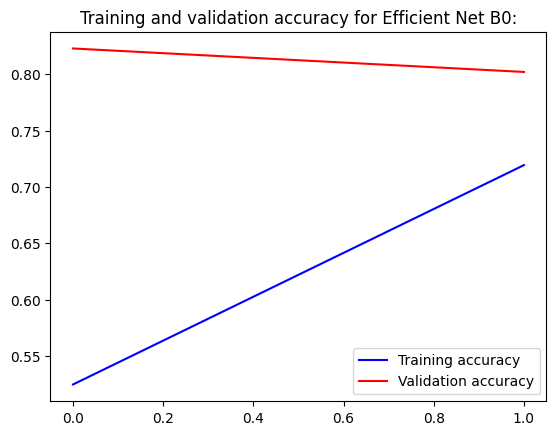

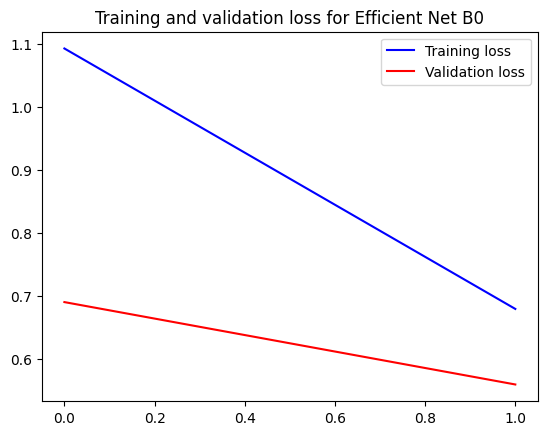

In [ ]:
accuracy = effnet_history.history['accuracy']
val_accuracy = effnet_history.history['val_accuracy']

loss = effnet_history.history['loss']
val_loss = effnet_history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy for Efficient Net B0:')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss for Efficient Net B0')
plt.legend()
plt.show()

In [ ]:


# Predict the label of the test_images
pred = effnet_model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
print("Efficient Net B0 classification report:")
print(classification_report(y_test, pred))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step
Efficient Net B0 classification report:
                 precision    recall  f1-score   support

   Benign cases       0.25      0.15      0.19        26
Malignant cases       0.99      0.97      0.98       117
   Normal cases       0.75      0.87      0.81        77

       accuracy                           0.84       220
      macro avg       0.66      0.67      0.66       220
   weighted avg       0.82      0.84      0.83       220

